In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from collections import Counter
import seaborn as sns
from sklearn.metrics import roc_curve,auc

import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout
from keras.layers import BatchNormalization

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

W0901 22:56:47.913790 140286681581376 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0901 22:56:47.915509 140286681581376 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0901 22:56:47.926423 140286681581376 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [3]:
df = pd.read_csv('train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']

In [4]:
meanX = X.mean(axis = 0)
stdX = X.std(axis = 0)
X_norm = (X-meanX)/stdX

In [5]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X_norm.loc[fraud_index]
honest = X_norm.loc[honest_index]

yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

In [6]:
h_used, x_trash, yh, y_trash = train_test_split(honest, yh, test_size = 0.75, random_state = 30)
x_used = pd.concat([h_used,fraud],ignore_index = False)
y_used = pd.concat([yh,yf],ignore_index=False)
x_train,x_test,y_train,y_test = train_test_split(x_used,y_used,test_size=0.3,random_state = 30)
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size=0.5,random_state = 30)

In [7]:
x_data = [x_train,x_val,x_test]
y_data = [y_train,y_val,y_test]

In [8]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [10]:
from keras.models import load_model
model3 = load_model('RNA3_elim.h5', custom_objects={'f1': f1})
model5 = load_model('RNA5_elim.h5', custom_objects={'f1': f1})
model1 = load_model('RNA1_elim.h5', custom_objects={'f1': f1})
model= load_model('model_newData.h5', custom_objects={'f1': f1})

W0901 22:56:58.426790 140286681581376 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0901 22:56:58.430804 140286681581376 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0901 22:56:58.476993 140286681581376 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0901 22:56:59.224785 140286681581376 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/optimizers.py:790: The name tf.tra

# Model 3

In [11]:
y_train_prob = np.ravel(model3.predict(x_train))
y_val_prob = np.ravel(model3.predict(x_val))
y_test_prob = np.ravel(model3.predict(x_test))

y_prob_m3 = [y_train_prob,y_val_prob,y_test_prob]

In [12]:
threshold = 0.9
y_hat_m3 = []
aux = []
for j in range(len(y_prob_m3)):
    for i in range(len(y_prob_m3[j])):
        if y_prob_m3[j][i] > threshold:
            aux.append(1)
        else:
            aux.append(0)
    aux = np.asarray(aux)
    y_hat_m3.append(aux)
    aux = []
y_hat_m3 = np.asarray(y_hat_m3)
y_prob_m3 = np.asarray(y_prob_m3)

# Model5

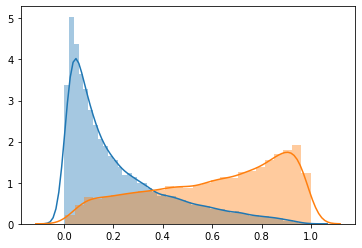

In [13]:
y_train_prob = np.ravel(model5.predict(x_train))
index0 = np.ravel(np.where(y_data[0] == 0 ))
index1= np.ravel(np.where(y_data[0] == 1))
sns.distplot(y_train_prob[index0])
sns.distplot(y_train_prob[index1])

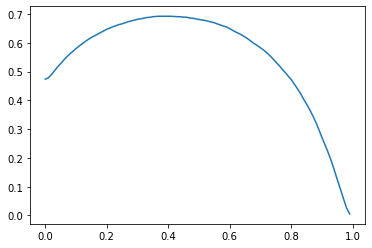

In [14]:
aux = []
score = []
treshold_list = []

for i in np.arange(0,1,0.01):
    for j in range(len(y_train_prob)):
        if y_train_prob[j]>i:
            aux.append(1)
        else:
            aux.append(0)
    treshold_list.append(i)
    score.append(f1_score(y_data[0],aux))
    aux = []
plt.plot(treshold_list,score)

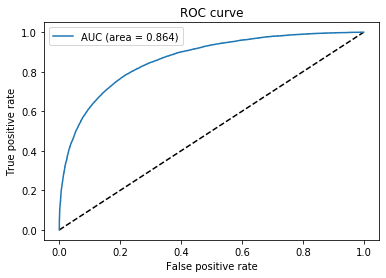

In [15]:
_max = max(score)
max_index = score.index(_max)
threshold = max_index*0.01


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_data[0],y_train_prob)
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [16]:
y_train_prob = np.ravel(model5.predict(x_train))
y_val_prob = np.ravel(model5.predict(x_val))
y_test_prob = np.ravel(model5.predict(x_test))

y_prob_m5 = [y_train_prob,y_val_prob,y_test_prob]

In [17]:
y_hat_m5 = []
aux = []
for j in range(len(y_prob_m5)):
    for i in range(len(y_prob_m5[j])):
        if y_prob_m5[j][i] > threshold:
            aux.append(1)
        else:
            aux.append(0)
    aux = np.asarray(aux)
    y_hat_m5.append(aux)
    aux = []
y_hat_m5 = np.asarray(y_hat_m5)
y_prob_m5 = np.asarray(y_prob_m5)

# Model 1

In [18]:
y_train_prob = np.ravel(model1.predict(x_train))
y_val_prob = np.ravel(model1.predict(x_val))
y_test_prob = np.ravel(model1.predict(x_test))

y_prob_m1 = [y_train_prob,y_val_prob,y_test_prob]

In [19]:
threshold = 0.02
y_hat_m1 = []
aux = []
for j in range(len(y_prob_m1)):
    for i in range(len(y_prob_m1[j])):
        if y_prob_m1[j][i] > threshold:
            aux.append(1)
        else:
            aux.append(0)
    aux = np.asarray(aux)
    y_hat_m1.append(aux)
    aux = []
y_hat_m1 = np.asarray(y_hat_m1)
y_prob_m1 = np.asarray(y_prob_m1)

# Creating new DataFrames, Input to the Final Model

In [20]:
data2 = [np.vstack((y_hat_m3[0],y_prob_m3[0],y_hat_m5[0],y_prob_m5[0],y_hat_m1[0],y_prob_m1[0])).T,
         np.vstack((y_hat_m3[1],y_prob_m3[1],y_hat_m5[1],y_prob_m5[1],y_hat_m1[1],y_prob_m1[1])).T,
         np.vstack((y_hat_m3[2],y_prob_m3[2],y_hat_m5[2],y_prob_m5[2],y_hat_m1[2],y_prob_m1[2])).T] 

_layers = [y_train,y_val,y_test]

In [21]:
new_data = []
average = []
p0 = []
p1 = []
for i in range(len(data2)):
    aux =  pd.DataFrame(data = data2[i], columns = ['hat_m3','prob_m3','hat_m5','prob_m5','hat_m1','prob_m1'])
    average = pd.DataFrame(aux.iloc[:,[1,3,5]].mean(axis = 1, skipna = True),columns=['mean'])
    aux = aux.join(average.reset_index(drop=True)) 
    aux = aux.join(_layers[i].reset_index(drop=True))
    aux['id'] = aux.index
    aux.set_index('id',inplace = True)
    p0.append(aux.loc[(aux['hat_m3']==0) & (aux['hat_m5']==0) & (aux['hat_m1'] ==0)])
    p1.append(aux.loc[(aux['hat_m3']==1) & (aux['hat_m5']==1) & (aux['hat_m1'] ==1)])
    aux =  aux.drop(p0[i].index)
    aux =  aux.drop(p1[i].index)
    new_data.append(aux)

### Pegando as repostas do modelo 3 para os dados P0

In [22]:
aux_prob = []
hat_p0 = []
prob_p0 = []
aux_hat = []
for i in range(len(p0)):
    for j in p0[i].index:
        aux_prob.append(y_prob_m3[i][j])
        aux_hat.append(y_hat_m3[i][j])
    prob_p0.append(aux_prob)
    hat_p0.append(aux_hat)
    aux_prob = []
    aux_hat = []

### Pegando as repostas do modelo 5 para os dados P1

In [23]:
aux_prob= []
hat_p1 = []
prob_p1 = []
aux_hat = []
for i in range(len(p1)):
    for j in p1[i].index:
        aux_prob.append(y_prob_m1[i][j])
        aux_hat.append(y_hat_m1[i][j])
    prob_p1.append(aux_prob)
    hat_p1.append(aux_hat)
    aux_prob = []
    aux_hat = []

### Para os casos fora de P0 e P1, iremos passar por uma quarta rede 

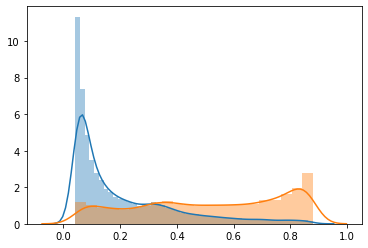

In [24]:
y_train_prob = np.ravel(model.predict(new_data[0].loc[:,'hat_m3':'mean']))
index0 = np.ravel(np.where(new_data[0].loc[:,'target'] == 0 ))
index1= np.ravel(np.where(new_data[0].loc[:,'target']  == 1))
sns.distplot(y_train_prob[index0])
sns.distplot(y_train_prob[index1])

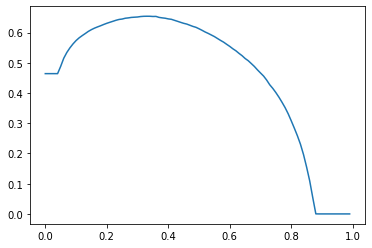

In [25]:
aux = []
score = []
treshold_list = []

for i in np.arange(0,1,0.01):
    for j in range(len(y_train_prob)):
        if y_train_prob[j]>i:
            aux.append(1)
        else:
            aux.append(0)
    treshold_list.append(i)
    score.append(f1_score(new_data[0].loc[:,'target'],aux))
    aux = []

plt.plot(treshold_list,score)

y_val_prob = np.ravel(model.predict(new_data[1].loc[:,'hat_m3':'mean']))
y_test_prob = np.ravel(model.predict(new_data[2].loc[:,'hat_m3':'mean']))

y_prob = [y_train_prob,y_val_prob,y_test_prob]

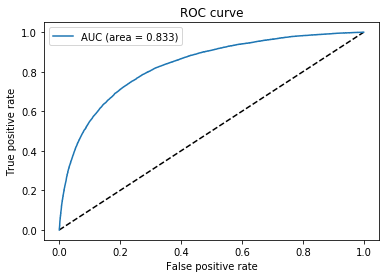

In [26]:
_max = max(score)
max_index = score.index(_max)
threshold = max_index*0.01


fpr_keras, tpr_keras, thresholds_keras = roc_curve(new_data[0].loc[:,'target'],y_train_prob)
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [27]:
y_hat = []
aux = []
for j in range(len(y_prob)):
    for i in range(len(y_prob[j])):
        if y_prob[j][i] > threshold:
            aux.append(1)
        else:
            aux.append(0)
    aux = np.asarray(aux)
    y_hat.append(aux)
    aux = []
y_hat = np.asarray(y_hat)
y_prob = np.asarray(y_prob)

In [28]:
for i in range(len(y_prob)):
    new_data[i]['prob'] = y_prob[i]
    new_data[i]['hat'] = y_hat[i]

In [29]:
new_data[0].head()

,hat_m3,prob_m3,hat_m5,prob_m5,hat_m1,prob_m1,mean,target,prob,hat
id,,,,,,,,,,
0,0.0,0.067238,0.0,0.098672,1.0,0.065888,0.077266,0,0.071033,0
1,0.0,0.131740,0.0,0.126287,1.0,0.131278,0.129769,0,0.105419,0
2,0.0,0.281910,0.0,0.322745,1.0,0.293125,0.299260,1,0.285477,0
4,0.0,0.077893,0.0,0.079033,1.0,0.073392,0.076773,0,0.069004,0
5,0.0,0.396283,1.0,0.402749,1.0,0.380657,0.393230,1,0.371776,1


### Agrupando as respostas das 3 RNN 

In [30]:
prob0_train = pd.DataFrame(prob_p0[0])
prob0_train = prob0_train.join(pd.DataFrame(p0[0].index,columns=['id']))
prob0_train.set_index('id',inplace = True)
prob0_val = pd.DataFrame(prob_p0[1])
prob0_val = prob0_val.join(pd.DataFrame(p0[1].index,columns=['id']))
prob0_val.set_index('id',inplace = True)
prob0_test = pd.DataFrame(prob_p0[2])
prob0_test = prob0_test.join(pd.DataFrame(p0[2].index,columns=['id']))
prob0_test.set_index('id',inplace = True)

prob1_train = pd.DataFrame(prob_p1[0])
prob1_train = prob1_train.join(pd.DataFrame(p1[0].index,columns=['id']))
prob1_train.set_index('id',inplace = True)
prob1_val = pd.DataFrame(prob_p1[1])
prob1_val = prob1_val.join(pd.DataFrame(p1[1].index,columns=['id']))
prob1_val.set_index('id',inplace = True)
prob1_test = pd.DataFrame(prob_p1[2])
prob1_test = prob1_test.join(pd.DataFrame(p1[2].index,columns=['id']))
prob1_test.set_index('id',inplace = True)

hat0_train = pd.DataFrame(hat_p0[0])
hat0_train = hat0_train.join(pd.DataFrame(p0[0].index,columns=['id']))
hat0_train.set_index('id',inplace = True)
hat0_val = pd.DataFrame(hat_p0[1])
hat0_val = hat0_val.join(pd.DataFrame(p0[1].index,columns=['id']))
hat0_val.set_index('id',inplace = True)
hat0_test = pd.DataFrame(hat_p0[2])
hat0_test = hat0_test.join(pd.DataFrame(p0[2].index,columns=['id']))
hat0_test.set_index('id',inplace = True)

hat1_train = pd.DataFrame(hat_p1[0])
hat1_train = hat1_train.join(pd.DataFrame(p1[0].index,columns=['id']))
hat1_train.set_index('id',inplace = True)
hat1_val = pd.DataFrame(hat_p1[1])
hat1_val = hat1_val.join(pd.DataFrame(p1[1].index,columns=['id']))
hat1_val.set_index('id',inplace = True)
hat1_test = pd.DataFrame(hat_p1[2])
hat1_test = hat1_test.join(pd.DataFrame(p1[2].index,columns=['id']))
hat1_test.set_index('id',inplace = True)

In [31]:
prob_train = pd.concat([prob0_train,prob1_train],axis=0)
prob_train = prob_train.sort_values(by ='id',axis = 0)
prob_train.columns = ['prob']
prob_val = pd.concat([prob0_val,prob1_val],axis=0)
prob_val = prob_val.sort_values(by ='id')
prob_val.columns = ['prob']
prob_test = pd.concat([prob0_test,prob1_test],axis=0)
prob_test = prob_test.sort_values(by ='id',axis = 0)
prob_test.columns = ['prob']

hat_train = pd.concat([hat0_train,hat1_train],axis=0)
hat_train = hat_train.sort_values(by ='id',axis = 0)
hat_train.columns = ['hat']
hat_val = pd.concat([hat0_val,hat1_val],axis=0)
hat_val = hat_val.sort_values(by ='id',axis = 0)
hat_val.columns = ['hat']
hat_test = pd.concat([hat0_test,hat1_test],axis=0)
hat_test = hat_test.sort_values(by ='id',axis = 0)
hat_test.columns = ['hat']

prob0_train=None
prob0_val=None
prob0_test=None
prob1_train=None
prob1_val=None
prob1_test=None
hat0_train = None
hat0_val = None
hat0_test = None
hat1_train = None
hat1_val = None
hat1_test = None

In [32]:
train = pd.concat([prob_train,hat_train],axis=1)
val   = pd.concat([prob_val,hat_val],axis=1)
test  = pd.concat([prob_test,hat_test],axis=1)

ans_train=None
ans_val  =None
ans_test =None

In [33]:
ans_train = pd.concat([pd.DataFrame(new_data[0].loc[:,'prob':'hat']),train],axis=0)
ans_val = pd.concat([pd.DataFrame(new_data[1].loc[:,'prob':'hat']),val],axis=0)
ans_test = pd.concat([pd.DataFrame(new_data[2].loc[:,'prob':'hat']),test],axis=0)

ans_train = ans_train.sort_values(by='id',axis = 0)
ans_val = ans_val.sort_values(by='id',axis = 0)
ans_test = ans_test.sort_values(by='id',axis = 0)

ans = [ans_train,ans_val,ans_test]

train=None
val  =None
test =None

In [34]:
ans[0].head()

,prob,hat
id,,
0,0.071033,0
1,0.105419,0
2,0.285477,0
3,0.963048,1
4,0.069004,0


### Verificando se houve uma melhora de performance

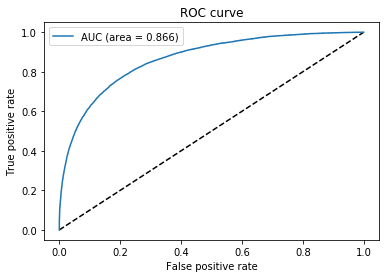

In [35]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(_layers[0],ans[0].loc[:,'prob'])
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()